# How a camera works

## Pinhole / Linear camera model

<a>
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Pinhole-camera.svg/1200px-Pinhole-camera.svg.png" alt="Pinhole camera" width="480" style="background-color: white;padding: 10px;">
</a>

The pinhole camera model is the simplest, most widely used theoretical camera model:

-  There’s a tiny hole (pinhole) through which light enters.
- No lenses or distortions are considered.
- The 3D world is projected onto a 2D image plane using straight lines.
- It follows a linear projection, described mathematically as: $s \cdot (x) = (K) \cdot (R|t) \cdot (X)$

### Extrinsic & intrinsic camera parameters
**Camera Pose (position, orientation) & camera calibration matrix**

<a>
  <img src="https://docs.nvidia.com/vpi/pinhole_camera.svg" alt="Pinhole camera coordinates" width="480" style="background-color: white; padding: 10px;"/>
</a>

<img src="../images/camera_coordinates.png" alt="Camera Coordinates" width="480" style="background-color: white;padding: 10px;"/>

#### image coordinates & world coordinates
- (u,v) are the 2D image coordinates [in px] of the 3D point which is displayed in the image

- (x,y,z) are the 3D coordinates of the point [in m]

#### extrinsic parameters

- (R|t) ist eine Matrix, die die Rotation und Translation des Kamerakoordinatensystems relativ zum Weltkoordinatensystem beschreibt.

#### intrinsic parameters
**K: camera calibration matrix**

- f: focal length; along z-axis (liegt ursprünglich in Millimeter vor (z. B. 35 mm Objektiv), aber durch die Sensor-Geometrie wird sie in Pixel umgerechnet). Als Faustregel gilt dabei: je kürzer die Brennweite, desto größer der Bildausschnitt.

    Die Brennweite f ist also ein Skalierungsfaktor. Nur geht die z-Komponente beim skalieren von 3D auf 2D verloren. Die beiden Skalierungsfaktoren f_x und f_y bleiben jedoch erhalten. Wären Pixel nun perfekt quadratisch, dann wären f_x und f_y gleich groß. Das sind sie jedoch häufig nicht. 


- c: principal point (theoretically: half of image height/width. Might deviate sligthly due to production tolerances. Gets calculated during camera calibration)

#### focal lenght

**Umrechnung Brennweite mm → Pixel**
    
$f_{px} = \frac {f_{mm} \cdot {w_{image width px}}} {{w_{sensor width mm}}}$

In [11]:
sensor_width_mm = 36  # z.B. Vollformatsensor
image_width_px = 1280
focal_length_mm = 50

f_px = (focal_length_mm * image_width_px) / sensor_width_mm
print(f"Brennweite in Pixel: {f_px:.2f}")

Brennweite in Pixel: 1777.78


<a>
  <img src="https://thedarkroom.com/app/uploads/2019/11/focal-length-angle-view-guide.svg" alt="focal length" width="480" style="background-color: white; padding: 10px;"/>
</a>

#### Additional information: Scale factor `s` & Skew `a`

$s 
\cdot 
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} =
\begin{bmatrix}
f_x & a & c_x\\
0 & f_y & c_y\\
0 & 0 & 1\\
\end{bmatrix}
\cdot
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_1\\
r_{21} & r_{22} & r_{23} & t_2\\
r_{31} & r_{32} & r_{33} & t_3\\
\end{bmatrix}
\cdot 
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
$

- `s` ist der Skalierungsfaktor für ein Kameramodell. Liegt das Kamerakoordinatensystem im Ursprung (und ist somit das Weltkoordinatensystem) entspricht der Skalierungsfaktor `s` gleich der Tiefe `z`.

- `a` ist die Scherung (skew). Wenn die Kamera-Sensor-Zeilen nicht exakt horizontal zur x-Achse verlaufen, entstehen nicht-orthogonale Pixel (z. B. bei alten Scankameras oder Projektionen mit Schräge). Dann ist die Scherung $`a \neq 0`$. Meist ist `a = 0`, weil moderne Kameras keine Scherung haben.


## Adding Linses & distortion

<a>
  <img src="https://learnopencv.com/wp-content/uploads/2019/10/radial-distortions-1024x352.png
  " alt="distortions" width="480" style="background-color: white; padding: 10px;"/>
</a>

- $\text{dist} = [k_1, k_2, p_1, p_2, k_3]$: distortion (Verzerrungskoeffizienten -> Bei realen Kameras sehr wichtig – sonst sind gerade Linien im Bild gebogen.)

    **Radiale Verzerrung**  
    Tritt auf, wenn Lichtstrahlen durch Linsenkrümmung abgelenkt werden. Sichtbar als "Fischaugen-Effekt".
    - `k1, k2, k3`

    **Tangentiale Verzerrung**  
    Tritt auf, wenn die Linse nicht perfekt zum Bildsensor ausgerichtet ist. Verursacht asymmetrische Verzerrungen.
    - `p1, p2`

Youtube Video mit Erklärung:

<a href="https://www.youtube.com/watch?v=qByYk6JggQU" target="_blank">
<img src="https://img.youtube.com/vi/qByYk6JggQU/maxresdefault.jpg" alt="Watch the video" width="500">
</a>

### Question: How to calculate 3D points from the real world to 2D points in the camera coordinate system. 

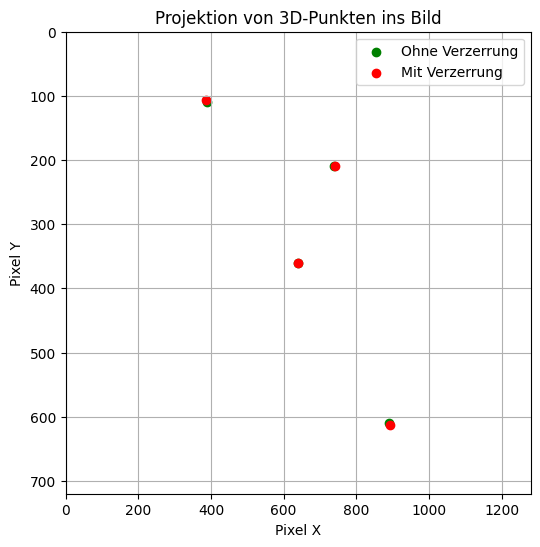

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte einer typischen Kamerakalibrierung (in Pixeln)
# Diese Werte bekommst du normalerweise durch ein Kalibrier-Skript mit Schachbrett-Bildern

# Intrinsische Kameramatrix
K = np.array([
    [1000, 0, 640],
    [0, 1000, 360],
    [0, 0, 1]
], dtype=np.float32)

# Verzerrungskoeffizienten (hier beispielhaft, wichtig für reale Kameras)
dist_coeffs = np.array([0.1, -0.05, 0, 0, 0], dtype=np.float32)

# Mehrere 3D-Punkte vor der Kamera
# Diese Vektoren anpassen
points_3D = np.array([
    [0, 0, 2],
    [0.5, 0.5, 2],
    [-0.5, -0.5, 2],
    [0.2, -0.3, 2]
], dtype=np.float32)

# Keine Rotation und Translation
rvec = np.zeros(3)
tvec = np.zeros(3)

# Projektion mit Verzerrung
image_points_distorted, _ = cv2.projectPoints(points_3D, rvec, tvec, K, dist_coeffs)

# Projektion ohne Verzerrung
image_points_undistorted, _ = cv2.projectPoints(points_3D, rvec, tvec, K, None)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(image_points_undistorted[:, 0, 0], image_points_undistorted[:, 0, 1], color='green', label='Ohne Verzerrung')
plt.scatter(image_points_distorted[:, 0, 0], image_points_distorted[:, 0, 1], color='red', label='Mit Verzerrung')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Projektion von 3D-Punkten ins Bild")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.legend()
plt.grid()
plt.show()

# Kameramodell und 3D-zu-2D-Projektion

In diesem Notebook wird gezeigt, wie ein 3D-Punkt mit bekannten Kameraparametern auf ein 2D-Bild projiziert wird. Dazu wird das **Pinhole-Kameramodell** verwendet.

---

## 1. Kamerakalibrierung

Wir definieren exemplarisch eine Kamera mit folgenden Parametern:

- **Intrinsische Matrix (K)**: Enthält Brennweiten und Bildmittelpunkt.
- **Verzerrungskoeffizienten**: Modellieren Linsenverzerrungen.

---

## 2. 3D-Punktprojektion

Ein Punkt im 3D-Raum wird mit der OpenCV-Funktion `cv2.projectPoints` auf das 2D-Bild projiziert.

---

## 3. Ergebnis

Die berechneten 2D-Koordinaten zeigen, wo der Punkt im Bild erscheint.

---

## 4. Nächste Schritte (optional)

- Mehrere Punkte projizieren
- Einfluss von Verzerrungen visualisieren
- Rotations- und Translationsvektoren variieren